In [1]:
%matplotlib inline


Emcee and the Model Interface
=============================


In [2]:
import corner
import matplotlib.pyplot as plt
import numpy as np

import lmfit

Set up a double-exponential function and create a Model



In [3]:
def double_exp(x, a1, t1, a2, t2):
    return a1*np.exp(-x/t1) + a2*np.exp(-(x-0.1) / t2)


model = lmfit.Model(double_exp)

Generate some fake data from the model with added noise



In [4]:
truths = (3.0, 2.0, -5.0, 10.0)
x = np.linspace(1, 10, 250)
np.random.seed(0)
y = double_exp(x, *truths)+0.1*np.random.randn(x.size)

Create model parameters and give them initial values



In [5]:
p = model.make_params(a1=4, t1=3, a2=4, t2=3)

Fit the model using a traditional minimizer, and show the output:



[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 609
    # data points      = 250
    # variables        = 4
    chi-square         = 2.33333982
    reduced chi-square = 0.00948512
    Akaike info crit   = -1160.54007
    Bayesian info crit = -1146.45423
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a1:  2.98623689 (init = 4)
    t1:  1.30993186 (init = 3)
    a2: -4.33525597 (init = 4)
    t2:  11.8240752 (init = 3)


/Users/mdonnelly/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/mdonnelly/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  
/Users/mdonnelly/opt/anaconda3/lib/python3.7/site-packages/lmfit/minimizer.py:182: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

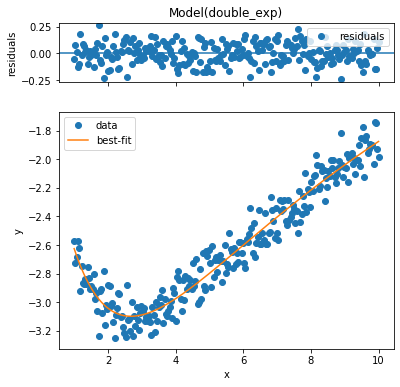

In [6]:
result = model.fit(data=y, params=p, x=x, method='Nelder', nan_policy='omit')

lmfit.report_fit(result)
result.plot()

Calculate parameter covariance using emcee:

 - start the walkers out at the best-fit values
 - set is_weighted to False to estimate the noise weights
 - set some sensible priors on the uncertainty to keep the MCMC in check




In [7]:
emcee_kws = dict(steps=1000, burn=300, thin=20, is_weighted=False,
                 progress=False)
emcee_params = result.params.copy()
emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

run the MCMC algorithm and show the results:



The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [42.15512406 49.13844172 47.97313337 48.69759859 39.90675732]
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 250
    # variables        = 5
    chi-square         = 245.611753
    reduced chi-square = 1.00249695
    Akaike info crit   = 5.57278242
    Bayesian info crit = 23.1800870
[[Variables]]
    a1:         2.99014520 +/- 0.15080185 (5.04%) (init = 2.986237)
    t1:         1.32465508 +/- 0.14246577 (10.75%) (init = 1.309932)
    a2:        -4.34626582 +/- 0.12518881 (2.88%) (init = -4.335256)
    t2:         11.7839459 +/- 0.48230303 (4.09%) (init = 11.82408)
    __lnsigma: -2.32797933 +/- 0.04489245 (1.93%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, t2) =  0.981
    C(t1, a2) = -0.939
    C(t1, t2) = -0.898
    C(a1, t1)

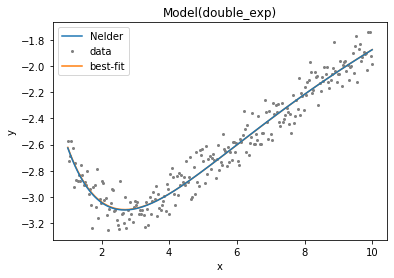

In [8]:
result_emcee = model.fit(data=y, x=x, params=emcee_params, method='emcee',
                         nan_policy='omit', fit_kws=emcee_kws)

lmfit.report_fit(result_emcee)

ax = plt.plot(x, model.eval(params=result.params, x=x), label='Nelder', zorder=100)
result_emcee.plot_fit(ax=ax, data_kws=dict(color='gray', markersize=2))
plt.show()

check the acceptance fraction to see whether emcee performed well



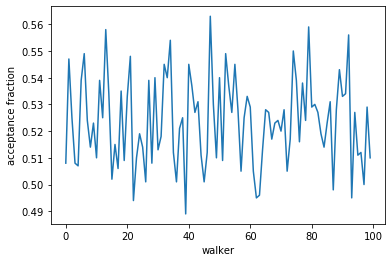

In [9]:
plt.plot(result_emcee.acceptance_fraction)
plt.xlabel('walker')
plt.ylabel('acceptance fraction')
plt.show()

try to compute the autocorrelation time



In [10]:
if hasattr(result_emcee, "acor"):
    print("Autocorrelation time for the parameters:")
    print("----------------------------------------")
    for i, p in enumerate(result.params):
        print(p, result.acor[i])

Plot the parameter covariances returned by emcee using corner



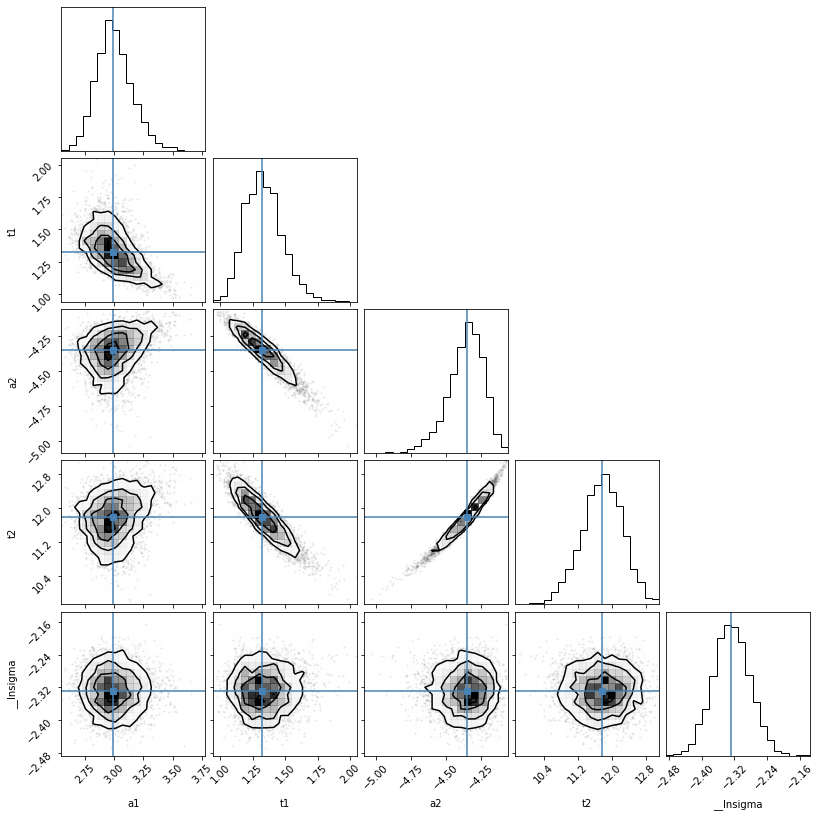

In [11]:
emcee_corner = corner.corner(result_emcee.flatchain, labels=result_emcee.var_names,
                             truths=list(result_emcee.params.valuesdict().values()))

In [12]:
print("\nmedian of posterior probability distribution")
print('--------------------------------------------')
lmfit.report_fit(result_emcee.params)

# find the maximum likelihood solution
highest_prob = np.argmax(result_emcee.lnprob)
hp_loc = np.unravel_index(highest_prob, result_emcee.lnprob.shape)
mle_soln = result_emcee.chain[hp_loc]
print("\nMaximum likelihood Estimation")
print('-----------------------------')
for ix, param in enumerate(emcee_params):
    print(param + ': ' + str(mle_soln[ix]))

quantiles = np.percentile(result_emcee.flatchain['t1'], [2.28, 15.9, 50, 84.2, 97.7])
print("\n\n1 sigma spread", 0.5 * (quantiles[3] - quantiles[1]))
print("2 sigma spread", 0.5 * (quantiles[4] - quantiles[0]))


median of posterior probability distribution
--------------------------------------------
[[Variables]]
    a1:         2.99014520 +/- 0.15080185 (5.04%) (init = 2.986237)
    t1:         1.32465508 +/- 0.14246577 (10.75%) (init = 1.309932)
    a2:        -4.34626582 +/- 0.12518881 (2.88%) (init = -4.335256)
    t2:         11.7839459 +/- 0.48230303 (4.09%) (init = 11.82408)
    __lnsigma: -2.32797933 +/- 0.04489245 (1.93%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, t2) =  0.981
    C(t1, a2) = -0.939
    C(t1, t2) = -0.898
    C(a1, t1) = -0.540
    C(a1, a2) =  0.257
    C(a1, t2) =  0.225

Maximum likelihood Estimation
-----------------------------
a1: 2.9704980735108304
t1: 1.3209758260802968
a2: -4.338098241979906
t2: 11.838963811736026
__lnsigma: -2.3403986558500596


1 sigma spread 0.14233438845386803
2 sigma spread 0.2943016210688928
